# **Player Aggregation into Frame Metrics Table**

In [ ]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from matplotlib import pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
from functools import partial
from matplotlib.animation import writers
import os


#%matplotlib inline

In [ ]:
# Import from GoogleDrive

from google.colab import drive
drive.mount('/content/gdrive')
os.chdir("//content/gdrive/MyDrive/nfl-big-data-bowl-2023/")

data_dir = "/content/gdrive/My Drive/nfl-big-data-bowl-2023/"
save_dir = "/content/gdrive/My Drive/nfl-big-data-bowl-2023/charts/"
#if on kaggle
#data_dir = "/kaggle/input/nfl-big-data-bowl-2023/"

Mounted at /content/gdrive


In [ ]:
import sqlite3

# Create a SQL connection to a local SQLite database
con = sqlite3.connect(data_dir + "databowl.db")

**Frame Metrics Functions**

In [ ]:
#functions for aggregation of frame_metrics below
def get_distance(p, q):
    """ 
    Return euclidean distance between points p and q
    assuming both to have the same number of dimensions
    """
    # sum of squared difference between coordinates
    s_sq_difference = 0
    for p_i,q_i in zip(p,q):
        s_sq_difference += (p_i - q_i)**2
    
    # take sq root of sum of squared difference
    distance = s_sq_difference**0.5
    return distance

#look up the week by gameId

def get_week_by_gameId(game_id): 
    
    sql = "SELECT week FROM games WHERE (games.gameId=" + str(game_id) + ")"
    query = pd.read_sql_query(sql, con)
    for index, row in query.iterrows():
        week = row["week"]
    return week


def player_role(nfl_id):

    sql = """
           select pff_positionLinedUp from pffScoutingData as pff WHERE pff.nflId = """ + str(nfl_id) + """ 
    """  
    query = pd.read_sql_query(sql, con)
    return query

def metric_euclidean(offense_tracking, defender_tracking):
    #reference 1 variables, usually offensive player    
    x_y_coords = offense_tracking[['x', 'y']]
    records = x_y_coords.to_records(index=False)
    result = list(records)
    x_y_coords_list = result
    reference1_id = offense_tracking.iloc[0]['nflId']
    game_id = offense_tracking.iloc[0]['gameId']
    play_id = offense_tracking.iloc[0]['playId']
    ref1_role = player_role(reference1_id) #make a lookup of pff_position
    ref1_role = ref1_role.iloc[0]['pff_positionLinedUp']
    ref1_acceleration = 0 
    ref1_yards = offense_tracking['dis'].sum()
    ref1_avg_speed = 0 #avg(s), alter table ref1 speed, ref2 seed
    play_length = len(offense_tracking) * .1 #sum of frames


    #reference 2 variables, usually defender
    x_y_coords_defender = defender_tracking[['x', 'y']]
    defender_records = x_y_coords_defender.to_records(index=False)
    defender_result = list(defender_records)
    defender_x_y_coords_list = defender_result
    reference2_id = defender_tracking.iloc[0]['nflId']
    ref2_role = player_role(reference2_id) #make a lookup of pff_position
    ref2_role = ref2_role.iloc[0]['pff_positionLinedUp']
    #ref2_acceleration = defender_tracking['a'].max() 
    ref2_acceleration = 0 
    ref2_yards = defender_tracking['dis'].sum() #sum(dis), alter table ref1 yards, ref2 yards
    #ref2_avg_speed = defender_tracking['s'].mean() #avg(s), alter table ref1 speed, ref2 seed
    ref2_avg_speed = 0



    for c,k in enumerate(defender_x_y_coords_list):
      reference1_x = x_y_coords_list[c][0]
      reference1_y = x_y_coords_list[c][1]
      ref1_tuple = x_y_coords_list[c]
      reference2_x = defender_x_y_coords_list[c][0]
      reference2_y = defender_x_y_coords_list[c][1]
      ref2_tuple = defender_x_y_coords_list[c]
      euclidian_distance = get_distance(ref1_tuple, ref2_tuple)

    
      #write playId, gameId, nflId, x, y, euclidean to db
      # Create a new record
      cursor = con.cursor()
      sql = "INSERT INTO `frame_metrics` (`reference1_id`, `reference2_Id`, `reference1_x`, `reference1_y`, `gameId`, `playId`, `ref1_role`, `ref2_role`, `reference2_x`, `reference2_y`, `euclidean`, `ref1_acceleration`, `ref2_acceleration`, `ref1_yards`, `ref2_yards`, `ref1_avg_speed`, `ref2_avg_speed`, `play_length`) VALUES (" + str(reference1_id) + ", " + str(reference2_id) + ", " + str(reference1_x) +", " + str(reference1_y) + ", " + str(game_id) + ", " + str(play_id) + ", '" + ref1_role + "', '" + ref2_role + "', " + str(reference2_x) + ", " + str(reference2_y) + ", " + str(euclidian_distance) + ", " + str(ref1_acceleration) + "," + str(ref2_acceleration) + ", " + str(ref1_yards) + "," + str(ref2_yards) + ", " + str(ref1_avg_speed) + ", " + str(ref2_avg_speed) + "," + str(play_length) + ")"         
      print(sql)
      cursor.execute(sql)
      # the connection is not autocommited by default. So we must commit to save our changes.
      con.commit()



def player_tracking_clipped(nfl_id, game_id, play_id):

    sql = """
           select * from weeks as wk WHERE wk.nflId = """ + str(nfl_id) + """ 
           AND  wk.gameId = """ + str(game_id) + """ 
           AND  wk.playId = """ + str(play_id) + """ 
    """  
    query = pd.read_sql_query(sql, con)
    return query

def plays_tracking_by_OT(nfl_id):

    sql = """
           select DISTINCT wk.gameId, wk.playId from weeks as wk WHERE wk.nflId = """ + str(nfl_id) + """ 

    """  
    query = pd.read_sql_query(sql, con)
    return query


def defenseId_by_play(nfl_id, game_id, play_id):

    sql = """
           select DISTINCT(pff.pff_nflIdBlockedPlayer) from pffScoutingData as pff, weeks as wk where  pff.nflId = wk.nflId 
           and wk.nflId = """ + str(nfl_id) + """ 
           and wk.gameId =  """ + str(game_id) + """ 
           and wk.playId = """ + str(play_id) + """ 
           and wk.playId = pff.playId 
           and wk.gameId = pff.gameId
    """  
    query = pd.read_sql_query(sql, con)
    return query

def qbId_by_play(game_id, play_id):

    sql = """
           select pff.nflId from pffScoutingData as pff where pff.pff_role = 'Pass'  
           and pff.gameId =  """ + str(game_id) + """ 
           and pff.playId =  """ + str(play_id) + """ 
    """  
    query = pd.read_sql_query(sql, con)
    return query

def get_clipped_nflids_OT(): 
    sql = """
           select DISTINCT(wk.nflId) from pffScoutingData as pff, weeks as wk where pff.pff_positionLinedUp IN ('LT', 'RT') 
    AND pff.nflId = wk.nflId  
    """ 
    query = pd.read_sql_query(sql, con)
    return query

def min_plays(nfl_id):
    sql = """
           select COUNT(playId) as p_cnt from pffScoutingData where nflId = """+str(nfl_id)  
    query = pd.read_sql_query(sql, con)
    return query

def frame_metrics_exist(nfl_id):
    sql = """
           select COUNT(playId) as e_cnt from frame_metrics where reference1_id = """+str(nfl_id)  
    query = pd.read_sql_query(sql, con)
    return query

**Driver: Frame Metrics Aggregate Data, measure Euclidean for Plays**

In [ ]:

#get listing of unique blocker nflIds with at least 100 plays, best to aggregate staticly rather then automatically

#TODO: make get_clipped_nflids_OT() into a more generalized func that takes any position not just 'LT', 'RT'
clipped_nflids = get_clipped_nflids_OT()
#display(clipped_nflids)
nfl_ids = clipped_nflids[['nflId']]
agg_ids = []
nflid = nfl_ids['nflId'].values
for n in nflid:
  nfl_id = n

  #print(nfl_id)
  plays_cnt = min_plays(nfl_id)
  cnt = plays_cnt[['p_cnt']].values
  for c in cnt:
    min_cnt = c
    min_cnt = int(min_cnt)
    if min_cnt < 99:
      continue
    fm_exist = frame_metrics_exist(nfl_id)
    ee = fm_exist[['e_cnt']].values
    for e in ee:
      e_cnt = e
      if e_cnt > 0:
        continue

      #print(nfl_id,",", min_cnt)
      agg_ids.append(nfl_id)

print(agg_ids)
print()
print("ID cnt: ", len(agg_ids))

#get list of aggregation ids then paste into next cell 2 or 3 at a time to process manually, unless you have a dedicated computer to run and run and run.

KeyboardInterrupt: ignored

In [ ]:
'''

[
  
52480.0, 47805.0, 
52553.0, 52534.0, 
39146.0, 52590.0, 
39983.0
]

ID cnt:  27


'''



nfl_ids = [48220.0, 44841.0] 

#iterate over nflIds of blockers in  clip
for c,i in enumerate(nfl_ids):
  # then get playIds and gameIds
  nfl_id = i
  print(c, nfl_id)
  game_plays = plays_tracking_by_OT(nfl_id)
  for d,k in game_plays.iterrows():
    game_id = k['gameId']
    play_id = k['playId']

    #get blocked defensive players nflId for playId, gameId
    defense_id = defenseId_by_play(nfl_id, game_id, play_id)
    for e,l in defense_id.iterrows():
      blocker_id = l['pff_nflIdBlockedPlayer']
    if blocker_id is None:
      continue

    #offensive blocker tracking data
    player_tracking_for_play = player_tracking_clipped(nfl_id, game_id, play_id)
    #defender blocker tracking data
    defender_tracking_for_play = player_tracking_clipped(blocker_id, game_id, play_id)
    #qb defender tracking data
    qb_id = qbId_by_play(game_id, play_id)
    for f,m in qb_id.iterrows():
      qb_id = m['nflId']

    qb_tracking_for_play = player_tracking_clipped(qb_id, game_id, play_id)

    #measure euclideans for each tracking
    metric_euclidean(player_tracking_for_play, defender_tracking_for_play)
    metric_euclidean(qb_tracking_for_play, player_tracking_for_play)
    metric_euclidean(qb_tracking_for_play, defender_tracking_for_play)

Streaming output truncated to the last 5000 lines.
INSERT INTO `frame_metrics` (`reference1_id`, `reference2_Id`, `reference1_x`, `reference1_y`, `gameId`, `playId`, `ref1_role`, `ref2_role`, `reference2_x`, `reference2_y`, `euclidean`, `ref1_acceleration`, `ref2_acceleration`, `ref1_yards`, `ref2_yards`, `ref1_avg_speed`, `ref2_avg_speed`, `play_length`) VALUES (46101.0, 48220.0, 15.4, 23.64, 2021092602, 4003, 'QB', 'TE-iR', 19.81, 20.77, 5.261653732430517, 0,0, 10.43,10.759999999999998, 0, 0,6.2)
INSERT INTO `frame_metrics` (`reference1_id`, `reference2_Id`, `reference1_x`, `reference1_y`, `gameId`, `playId`, `ref1_role`, `ref2_role`, `reference2_x`, `reference2_y`, `euclidean`, `ref1_acceleration`, `ref2_acceleration`, `ref1_yards`, `ref2_yards`, `ref1_avg_speed`, `ref2_avg_speed`, `play_length`) VALUES (46101.0, 48220.0, 15.16, 23.63, 2021092602, 4003, 'QB', 'TE-iR', 19.57, 20.79, 5.245350321951814, 0,0, 10.43,10.759999999999998, 0, 0,6.2)
INSERT INTO `frame_metrics` (`reference1_i

KeyboardInterrupt: ignored

In [ ]:
#sql = "SELECT rowid from frame_metrics" #after 53522 nflId there are 292451 rows
#check that number of plays is correct per OT
#sql = "SELECT DISTINCT(playId) from frame_metrics where reference1_id = 53522"
#sql = "Select * from clipped_tracking where nflId = 43424"
#sql = "SELECT name FROM sqlite_schema WHERE type IN ('table', 'view') AND name NOT LIKE 'sqlite_%' ORDER BY 1"

sql = "Select count(rowid) from frame_metrics "
#sql = "select * FROM frame_metrics where reference1_id = 53436 OR reference2_id = 53436"
query = pd.read_sql_query(sql, con)
print(len(query))
print(con)
data = query.tail(200)
with pd.option_context('display.max_rows', None,):
  display(data)

1


,count(rowid)
0,1504102


# **5 on 5 Plots of Each Relevant Play**

This generates a plot for each play of the front the Offensive Line plus QB and the front 5 rushers of the Defense, 5 on 5 plot. It is currently a static function that must be manually set for each play that one would like to review, set the game, and play id numbers in xy_data, at cell line number 146:

frames, data_dict, play_id, game_id, x_data, y_data = get_animation_data(2021090900, 480, 1)

data frames:  40
data dict:  10
{1: ((45.19, 30.09, 92.63), (45.18, 30.09, 92.63), (45.16, 30.08, 91.4), (45.14, 30.08, 92.45), (45.13, 30.08, 94.42), (45.11, 30.09, 95.87), (45.07, 30.09, 97.89), (45.0, 30.09, 100.04), (44.87, 30.09, 101.96), (44.68, 30.12, 101.96), (44.46, 30.13, 103.24), (44.22, 30.17, 105.17), (43.98, 30.21, 107.83), (43.73, 30.25, 111.3), (43.5, 30.31, 116.39), (43.31, 30.39, 121.33), (43.13, 30.47, 123.87), (43.04, 30.55, 130.0), (42.97, 30.65, 134.48), (42.94, 30.76, 138.68), (42.94, 30.87, 147.81), (42.97, 30.98, 153.05), (43.0, 31.09, 161.06), (43.05, 31.21, 168.22), (43.09, 31.33, 178.04), (43.14, 31.45, 185.18), (43.19, 31.56, 191.96), (43.26, 31.67, 196.72), (43.34, 31.77, 203.12), (43.43, 31.86, 204.92), (43.53, 31.94, 200.6), (43.63, 31.97, 195.05), (43.72, 32.01, 182.14), (43.82, 32.04, 166.74), (43.91, 32.07, 160.99), (43.98, 32.1, 136.74), (44.05, 32.13, 120.04), (44.11, 32.17, 107.71), (44.14, 32.21, 106.34), (44.16, 32.26, 106.34)), 2: ((49.34, 30.0,

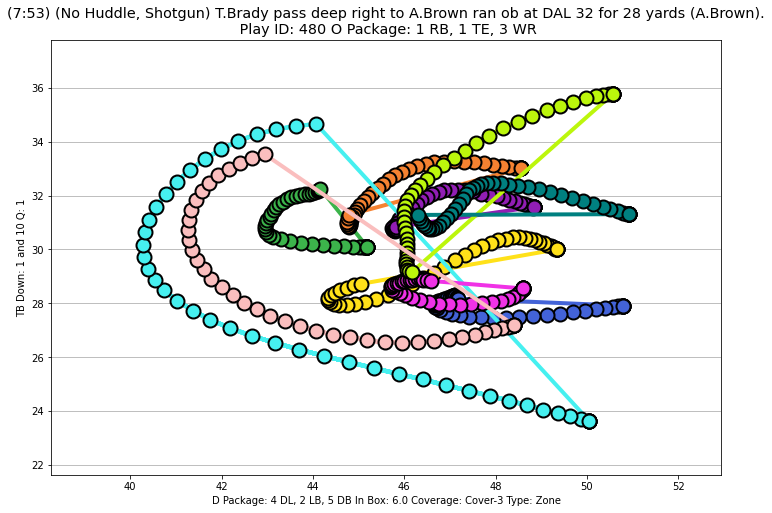

In [ ]:
#  https://stackoverflow.com/questions/63901823/matplotlib-animation-passing-variables-through-funcanimation
from functools import partial
import matplotlib as mpl



game_id = 2021090900

week = get_week_by_gameId(game_id)


#need a query to get nflIds of OL, QB, DL for play in game, then iterate through to clip for relevant data
#select DISTINCT(nflId) from pffScoutingData as sd where sd.playId = 97 and sd.gameId = 2021090900 AND sd.pff_role IN ('Pass Block', 'Pass Rush', 'Pass') 

#helper function convert list element to string

def tracking_by_nfl_id_limit(game_id, play_id, nfl_id, week, event):
    #event: 'ball_snap', 'pass_forward'

    sql = """select rowid from week""" + str(week) + """ as wk 
             where wk.gameid = """ + str(game_id) + """  
             AND wk.playId = """ + str(play_id) + """ 
             AND wk.nflId = """ + str(nfl_id) + """
             AND wk.event = '""" + event + """'
          """
    #print(sql)
    query = pd.read_sql_query(sql, con) 
    result = query['rowid'].tolist()
    #sometimes there are data errors missing 'pass_forward' or 'ball_snap' skip those plays
    if len(result) == 0:
        return None

    result = result[0]
    return result


def tracking_by_nfl_id(game_id, play_id, nfl_id, week, start_limit, end_limit):

    start_limit = start_limit - end_limit
    upper = end_limit + 1
    lower = 6 - 1
    sql = """select plays.passResult, wk.playId, wk.gameId, wk.nflId, wk.frameId, wk.time, wk.x, 
             wk.y, wk.s, wk.a, wk.dis, wk.o, wk.dir, wk.event from plays, week""" + str(week) + """ as wk 
             where plays.gameid = """ + str(game_id) + """  
             AND plays.playId = """ + str(play_id) + """   
			       AND wk.nflId = """ + str(nfl_id) + """ 
             AND plays.playId = wk.playId 
             AND plays.gameId = wk.gameId 
             AND wk.team != 'football'
			       LIMIT """ + str(lower) + """,""" + str(upper) + """ 
          """
    #print(sql)
    query = pd.read_sql_query(sql, con)
    return query

def get_play_info(game_id, play_id):
    sql = """select * from games, plays where games.gameId = 2021090900 AND plays.gameID = """ + str(game_id) + """  
        AND plays.playId = """+ str(play_id) + """
          """
    #print(sql)
    query = pd.read_sql_query(sql, con)
    return query

  #select * from games, plays where games.gameId = 2021090900 AND plays.gameID = 2021090900 AND plays.playId = 97


#get tracking data for each play by passResult
def get_animation_data(game_id, play_id, week):
    #game_id (int), play_id (int), team (str) i.e. 'TB', week (int), pass_result (int; 0,1), penalty (int:0,1)

    sql = """select DISTINCT(nflId) from pffScoutingData as sd where sd.playId = """ + str(play_id) + """ and sd.gameId = """ + str(game_id) + """
             AND sd.pff_role IN ('Pass Block', 'Pass Rush', 'Pass')
    """
    #iterate through nflIds, run query to retieve x,y,etc
    query = pd.read_sql_query(sql, con)

    records = query.to_records(index=False)
    result = list(records)

    x_y_coords_list = result
    nflIds = []
    coords_tuple = ()
    data_dict = {}
    x_data = []
    y_data = []

    k = 1
    for i in x_y_coords_list:
        key = k
        k += 1
        nflIds.append(i[0])
        player_id = i[0] #nflId

        start_limit = tracking_by_nfl_id_limit(game_id, play_id, player_id, week, 'ball_snap')
        if start_limit is None:
            continue
    
        end_limit = tracking_by_nfl_id_limit(game_id, play_id, player_id, week, 'pass_forward')
        if end_limit is None:
            continue

        tracking_records = tracking_by_nfl_id(game_id, play_id, player_id, week, start_limit, end_limit)
        frame_counter = len(tracking_records)
        data_dict_tuple = ()
        tracking_records = tracking_records[['x', 'y', 'o']]
        for index, row in tracking_records.iterrows():
            x = row["x"]
            y = row["y"]
            o = row["o"]
            coords = x,y,o
            coords_tuple = list(coords_tuple)
            coords_tuple.append(coords)
            data_dict_tuple = list(data_dict_tuple)
            data_dict_tuple.append(coords)
            coords_tuple = tuple(coords_tuple)
            data_dict_tuple = tuple(data_dict_tuple)
            x_data.append(x)
            y_data.append(y)
            
        data_dict[key] = data_dict_tuple

    return coords_tuple, frame_counter, data_dict, play_id, game_id, x_data, y_data
# end of function get_animation_data() #############################################



x1, x2, x3, x4, x5, x6, x7, x8, x9, x10, x11, x12, x13, x14, x15, x16, x17, x18, x19, x20, x21, x22 = [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [] 
y1, y2, y3, y4, y5, y6, y7, y8, y9, y10, y11, y12, y13, y14, y15, y16, y17, y18, y19, y20, y21, y22 = [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [] 
o1 = []

fig, ax = plt.subplots()
fig.set_figwidth(12)
fig.set_figheight(8)

plt.style.use("ggplot")

colors_list = [ '#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080', '#ffffff', '#000000', '#ff0000', '#808080']





#################### SET GAME ID AND PLAY ID HERE ##############################
#################### SET GAME ID AND PLAY ID HERE ##############################
#################### SET GAME ID AND PLAY ID HERE ##############################
xy_data, frames, data_dict, play_id, game_id, x_data, y_data = get_animation_data(2021090900, 480, 1) #returns a tuple of coords 
#################### SET GAME ID AND PLAY ID HERE ##############################
#################### SET GAME ID AND PLAY ID HERE ##############################
#################### SET GAME ID AND PLAY ID HERE ##############################






play_info = get_play_info(game_id, play_id)
#print(play_info)
play_description = play_info.iloc[0]['playDescription']
quarter = play_info.iloc[0]['quarter']
down = play_info.iloc[0]['down']
yards_to_go = play_info.iloc[0]['yardsToGo']
possession_team = play_info.iloc[0]['possessionTeam']
personnel_o = play_info.iloc[0]['personnelO']
personnel_d = play_info.iloc[0]['personnelD']
defenders_in_box = play_info.iloc[0]['defendersInBox']
pff_pass_coverage = play_info.iloc[0]['pff_passCoverage']
pff_pass_coverage_type = play_info.iloc[0]['pff_passCoverageType']


ax.set(title = play_description + "\n Play ID: " + str(play_id) + " O Package: "+personnel_o,
       xlabel = "D Package: " + personnel_d + " In Box: " + str(defenders_in_box) + " Coverage: " + pff_pass_coverage + " Type: "+pff_pass_coverage_type,
       ylabel = possession_team + " Down: " + str(down) + " and " + str(yards_to_go) + " Q: " + str(quarter)
       )

coords_xy = xy_data

max_val_x = max(x_data)
min_val_x = min(x_data)
max_val_y = max(y_data)
min_val_y = min(y_data)
ax.set_xlim(min_val_x-2, max_val_x+2)
ax.set_ylim(min_val_y-2, max_val_y+2)
ax.grid(axis='y')


data_frames = frames
frame_cnt = len(coords_xy)
print("data frames: ", data_frames)
print("data dict: ", len(data_dict))
print(data_dict)



def animation_frame(i, coords_xy, data_dict, data_frames): 
    data_dict_len = len(data_dict)
    #iterate through data_dict and append to x[key], y[key], l1 is value

    
    for k, v in data_dict.items():
        
        if(k == 1):
          data_copy = v
          data_copy = list(data_copy)
          x1.append(data_copy[i][0])
          y1.append(data_copy[i][1])
          o1.append(int(data_copy[i][2]))
          ax.plot(x1, y1, color=colors_list[k], linewidth=4)
          if(i == 0):
              ax.plot(x1, y1, color=colors_list[k], marker='o', markersize=14, markeredgewidth=2, markeredgecolor='#000000')

        if(k == 2):
          data_copy = v
          data_copy = list(data_copy)
          x2.append(data_copy[i][0])
          y2.append(data_copy[i][1])
          ax.plot(x2, y2, color=colors_list[k], linewidth=4)
          if(i == 0):
              ax.plot(x2, y2, color=colors_list[k], marker='o', markersize=14, markeredgewidth=2, markeredgecolor='#000000')

        if(k == 3):
          data_copy = v
          data_copy = list(data_copy)
          x3.append(data_copy[i][0])
          y3.append(data_copy[i][1])
          ax.plot(x3, y3, color=colors_list[k], linewidth=4)
          if(i == 0):
              ax.plot(x3, y3, color=colors_list[k], marker='o', markersize=14, markeredgewidth=2, markeredgecolor='#000000')

        if(k == 4):
          data_copy = v
          data_copy = list(data_copy)
          x4.append(data_copy[i][0])
          y4.append(data_copy[i][1])
          ax.plot(x4, y4, color=colors_list[k], linewidth=4)
          if(i == 0):
              ax.plot(x4, y4, color=colors_list[k], marker='o', markersize=14, markeredgewidth=2, markeredgecolor='#000000')

        if(k == 5):
          data_copy = v
          data_copy = list(data_copy)
          x5.append(data_copy[i][0])
          y5.append(data_copy[i][1])
          ax.plot(x5, y5, color=colors_list[k], linewidth=4)
          if(i == 0):
              ax.plot(x5, y5, color=colors_list[k], marker='o', markersize=14, markeredgewidth=2, markeredgecolor='#000000')

        if(k == 6):
          data_copy = v
          data_copy = list(data_copy)
          x6.append(data_copy[i][0])
          y6.append(data_copy[i][1])
          ax.plot(x6, y6, color=colors_list[k], linewidth=4)
          if(i == 0):
              ax.plot(x6, y6, color=colors_list[k], marker='o', markersize=14, markeredgewidth=2, markeredgecolor='#000000')

        if(k == 7):
          data_copy = v
          data_copy = list(data_copy)
          x7.append(data_copy[i][0])
          y7.append(data_copy[i][1])
          ax.plot(x7, y7, color=colors_list[k], linewidth=4)
          if(i == 0):
              ax.plot(x7, y7, color=colors_list[k], marker='o', markersize=14, markeredgewidth=2, markeredgecolor='#000000')

        if(k == 8):
          data_copy = v
          data_copy = list(data_copy)
          x8.append(data_copy[i][0])
          y8.append(data_copy[i][1])
          ax.plot(x8, y8, color=colors_list[k], linewidth=4)
          if(i == 0):
              ax.plot(x8, y8, color=colors_list[k], marker='o', markersize=14, markeredgewidth=2, markeredgecolor='#000000')

        if(k == 9):
          data_copy = v
          data_copy = list(data_copy)
          x9.append(data_copy[i][0])
          y9.append(data_copy[i][1])
          ax.plot(x9, y9, color=colors_list[k], linewidth=4)
          if(i == 0):
              ax.plot(x9, y9, color=colors_list[k], marker='o', markersize=14, markeredgewidth=2, markeredgecolor='#000000')

        if(k == 10):
          data_copy = v
          data_copy = list(data_copy)
          x10.append(data_copy[i][0])
          y10.append(data_copy[i][1])
          ax.plot(x10, y10, color=colors_list[k], linewidth=4)
          if(i == 0):
              ax.plot(x10, y10, color=colors_list[k], marker='o', markersize=14, markeredgewidth=2, markeredgecolor='#000000')

        if(k == 11):
          data_copy = v
          data_copy = list(data_copy)
          x11.append(data_copy[i][0])
          y11.append(data_copy[i][1])
          ax.plot(x11, y11, color=colors_list[k], linewidth=4)
          if(i == 0):
              ax.plot(x11, y11, color=colors_list[k], marker='o', markersize=14, markeredgewidth=2, markeredgecolor='#000000')
         

ani = FuncAnimation(fig,func=partial(animation_frame, coords_xy=xy_data, data_dict=data_dict, data_frames=data_frames), frames=np.arange(0, data_frames, 1), interval=1)
#ani = FuncAnimation(fig, func=animation_frame, frames=np.arange(0, frame_cnt, 1), interval=1)

from matplotlib.animation import writers
Writer = writers['ffmpeg']
writer = Writer(fps=10, metadata={'artist': 'Michael Joseph McCarron'}, bitrate=1800)

ani.save(str(game_id) + '_' + str(play_id) + '.mp4', writer)


In [ ]:
#48220
sql = "select * from frame_metrics where reference1_Id = 48220 OR reference2_id = 48220"

cursor = con.cursor()
# Execute the query
#cursor.execute(sql)
# the connection is not autocommited by default. So we must commit to save our changes.
#con.commit()

#con = sqlite3.connect(data_dir + "original_databowl.db")
#rows = pd.read_sql_query(sql, con)
#rows.tail(10)

query = pd.read_sql_query(sql, con)
#with pd.option_context('display.max_rows', None,):
#display(query)
print(len(query))


9606
